In [1]:
import numpy as np
import pandas as pd

import os

from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization, Dropout

import cv2

from keras.models import model_from_json
import time

## Function to read Images from both directories

In [2]:
def readDirectory(dirnameNormal, dirnamePneumonia):
    array1 = []
    array2 = []
    for i in os.listdir(dirnameNormal):
        if '.DS_Store' not in i:
            array1.append(dirnameNormal + '/' + str(i))
            array2.append(0)
        
    for i in os.listdir(dirnamePneumonia):
        if '.DS_Store' not in i:
            array1.append(dirnamePneumonia + '/' + str(i))
            array2.append(1)
        
    return array1, array2

In [3]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'

train_x, train_y = readDirectory(base_dir+'train/NORMAL', base_dir+'train/PNEUMONIA')
print('Reading on train directory finished!')

test_x, test_y = readDirectory(base_dir+'test/NORMAL', base_dir+'test/PNEUMONIA')
print('Reading on test directory finished!')

val_x, val_y = readDirectory(base_dir+'val/NORMAL', base_dir+'val/PNEUMONIA')
print('Reading on val directory finished!')

Reading on train directory finished!
Reading on test directory finished!
Reading on val directory finished!


In [4]:
print('Length verification before joining process!')
print(len(train_x), '<-->', len(train_y))
print(len(test_x), '<-->', len(test_y))
print(len(val_x), '<-->', len(val_y))

# Joining train and test lists into one.

files = train_x + test_x

# Joining train and test labels.

labels = train_y + test_y

print('Length verificacion after joining process!')
print(len(files), '<-->', len(labels))

Length verification before joining process!
5216 <--> 5216
624 <--> 624
16 <--> 16
Length verificacion after joining process!
5840 <--> 5840


## Shuffling and splitting of Dataset

In [5]:
from sklearn.utils import shuffle

files_shuffled, labels_shuffled = shuffle(files, labels)

## Train and Test split

In [6]:
from sklearn.model_selection import train_test_split

X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(files_shuffled, labels_shuffled, test_size=0.2, random_state=1)


## Custom Generator and Image Preprocessing

In [7]:
from skimage.io import imread
from skimage.transform import resize

# This class inherit Sequence class in order to create a custom generator
class Data_Generator(Sequence):
    
    # We feed oun gerator with our parameters.
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        
    # Computes the number of batches to produce.
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    # We preprocess our dataset with the current batch (Here is where magic happens).
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        return np.array(
            [self.preprocess_image(directory) for directory in batch_x]
        ), np.array(batch_y)
        
    
    # Preprocess a single image and return an array.
    def preprocess_image(self, directory):
        # Read image from directory
        img = cv2.imread(directory, cv2.IMREAD_GRAYSCALE)
        # Resize the image
        img = cv2.resize(src= img, dsize= (300, 300), interpolation = cv2.INTER_AREA)
        # Denoise the image
        img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
        # Normalize the image
        img = img/255
        
        img.shape += (1,)
        
        return img

In [8]:
# Preprocess a single image and return an array.
def preprocess_image(directory):
    # Read image from directory
    img = cv2.imread(directory, cv2.IMREAD_GRAYSCALE)
    # Resize the image
    img = cv2.resize(src= img, dsize= (300, 300), interpolation = cv2.INTER_AREA)
    # Denoise the image
    img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
    # Normalize the image
    img = img/255
        
    img.shape += (1,)
    
    return img

## Instantiation of our Data Generator with 64 epochs

In [9]:
batch_size = 64

my_training_batch_generator = Data_Generator(X_train_filenames, y_train, batch_size)
my_validation_batch_generator = Data_Generator(X_val_filenames, y_val, batch_size)


## Creation of the Convolutional Neural Network

In [10]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation="relu", input_shape=(300, 300, 1)))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation="tanh"))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation="tanh"))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation="tanh"))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'sigmoid', units = 1))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        1

In [11]:
history = model.fit_generator(
    generator=my_training_batch_generator,
    steps_per_epoch = int( np.ceil(len(X_train_filenames) / batch_size)),
    epochs= 5,
    verbose= 1,
    validation_data= my_validation_batch_generator,
    validation_steps= int( np.ceil(len(X_val_filenames) / batch_size)),
    use_multiprocessing=True
)

Epoch 1/5
73/73 [==============================] - 849s 12s/step - loss: 0.4730 - accuracy: 0.7802 - val_loss: 0.2899 - val_accuracy: 0.8673
Epoch 2/5
73/73 [==============================] - 906s 12s/step - loss: 0.2119 - accuracy: 0.9148 - val_loss: 0.1622 - val_accuracy: 0.9298
Epoch 3/5
73/73 [==============================] - 846s 12s/step - loss: 0.1638 - accuracy: 0.9356 - val_loss: 0.1628 - val_accuracy: 0.9366
Epoch 4/5
73/73 [==============================] - 819s 11s/step - loss: 0.1423 - accuracy: 0.9488 - val_loss: 0.1309 - val_accuracy: 0.9478
Epoch 5/5
73/73 [==============================] - 842s 12s/step - loss: 0.1268 - accuracy: 0.9527 - val_loss: 0.1201 - val_accuracy: 0.9572


In [13]:
def guardar_pesos(nombre_archivo='pesos.h5'):
    model.save_weights(nombre_archivo)

def guardar_modelo(nombre_archivo='modelo.json'):
    modelo_json = model.to_json()
    with open(nombre_archivo, "w") as json_file:
        json_file.write(modelo_json)
        
guardar_pesos()
guardar_modelo()

In [14]:
accuracy_training = history.history['accuracy']
accuracy_testing = history.history['val_accuracy']
epochs = 5

In [15]:
acc_training = np.array(accuracy_training)
acc_testing = np.array(accuracy_testing)

In [17]:
dataframe_accuracies = pd.DataFrame(list(zip(acc_training, acc_testing)), columns=['ACC_Training', 'ACC_Testing'])

In [19]:
dataframe_accuracies.to_csv('dataframe_accuracies.csv')
dataframe_accuracies.head()

,ACC_Training,ACC_Testing
0,0.780180,0.867295
1,0.914812,0.929795
2,0.935574,0.936644
3,0.948844,0.947774
4,0.952697,0.957192


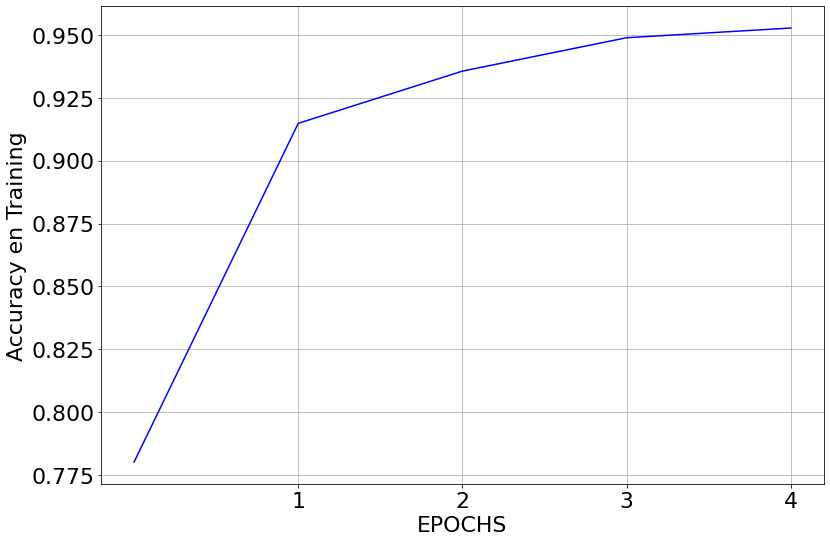

In [22]:
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 22})

plt.rcParams["figure.figsize"] = (12,8)
plt.grid()
plt.plot(accuracy_training, color='b', label="Training accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.xlabel('EPOCHS')
plt.ylabel('Accuracy en Training')
plt.tight_layout()
plt.show()

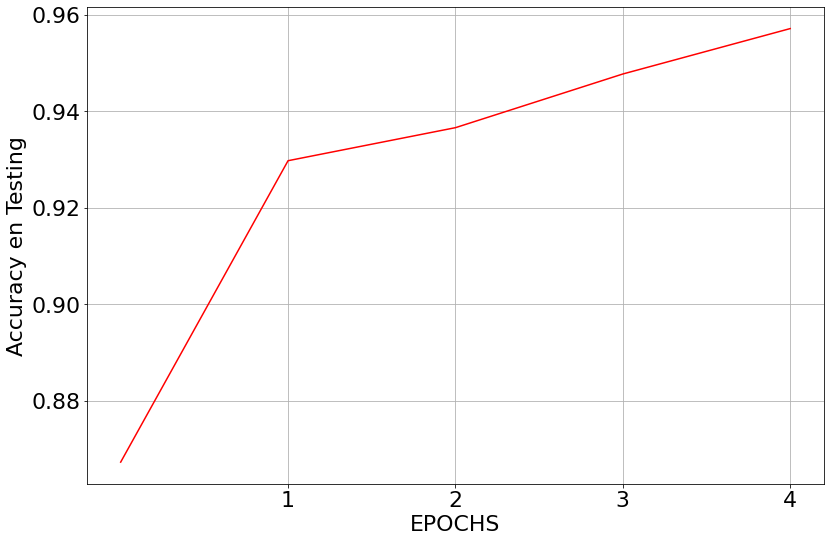

In [23]:
plt.rcParams["figure.figsize"] = (12,8)
plt.grid()
plt.plot(accuracy_testing, color='r')
plt.xticks(np.arange(1, epochs, 1))
plt.xlabel('EPOCHS')
plt.ylabel('Accuracy en Validation')
plt.tight_layout()
plt.show()